In [3]:
import pandas as pd
import statistics
import random
import numpy as np
from tensorflow import keras
from scipy.stats import multivariate_normal
from imblearn.over_sampling import SMOTE
import shap
import joblib
from xgboost import XGBClassifier, XGBRegressor
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr, spearmanr, chi2_contingency, pointbiserialr, f_oneway
from sklearn.preprocessing import StandardScaler,Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, f1_score, precision_score, recall_score
pd.options.mode.chained_assignment = None
TF_ENABLE_ONEDNN_OPTS=0

In [2]:
df = pd.read_csv("creditcard.csv")
df_train = pd.read_csv("creditcard_2023.csv")

In [4]:
df_train.shape

(568630, 31)

In [5]:
df.shape

(284807, 31)

In [73]:
new_data_test = df.drop(columns = ['Time', 'Class'], axis = 1)
y_new = df['Class']
x = df_train.drop(columns = ['id', 'Class'], axis = 1)
y = df_train['Class']

In [74]:
# split the dataset in to training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(new_data_test, y_new, test_size=0.2, random_state=42)

In [75]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [76]:
x_test.shape

(56962, 29)

In [77]:
print("Class 0: ",((y_train == 1).sum()/len(y_train))*100, "%")
print("Class 1: ",((y_train == 0).sum()/len(y_train))*100, "%")

Class 0:  50.0 %
Class 1:  50.0 %


In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train) #returns a numpy array
X_test_scaled = scaler.transform(x_test)

In [79]:
#visualizing the scaled training data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=x_train.columns, index=x_train.index)
X_train_scaled_df.shape

(454902, 29)

# Autoencoder = 100 epochs    FFNN = 50 epochs  

In [13]:
X_train_Autoencoder = X_train_scaled_df[y_train == 0]
#models.Sequential is a model from Keras where each layer feeds as input to the next layer.

autoencoder = models.Sequential([
    layers.Input(shape=(X_train_Autoencoder.shape[1],)),
    layers.Dense(32, activation='relu'), #(ReLu - Rectified Linear Unit) #encoding/compression
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(16, activation='relu'), #Process of decoding starts
    layers.Dense(32, activation='relu'),
    layers.Dense(X_train_Autoencoder.shape[1], activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with normal data
history = autoencoder.fit(X_train_Autoencoder, X_train_Autoencoder,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)



2024-11-27 22:46:55.947207: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4840 - val_loss: 0.3646
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3568 - val_loss: 0.3525
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3450 - val_loss: 0.3468
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3389 - val_loss: 0.3438
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3521 - val_loss: 0.3397
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3336 - val_loss: 0.3376
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3417 - val_loss: 0.3362
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3331 - val_loss: 0.3349
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3402 - val_loss: 0.3340
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3315 - val_loss: 0.3329
Epoch 11/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3305 - val_loss: 0.3300
Epoch 12/100
800/800 ━━━━━━━━━━━━━━━━━━━━

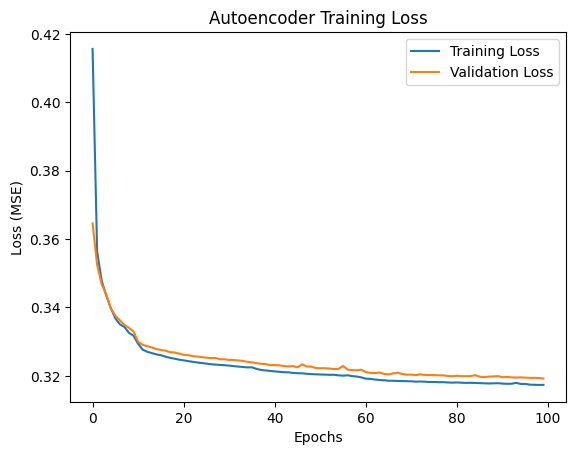

In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [15]:
X_train_reconstructions = autoencoder.predict(X_train_scaled_df)
mse_train = np.mean(np.power(X_train_scaled_df - X_train_reconstructions, 2), axis=1)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=x_test.columns, index=x_test.index)
X_test_reconstructions = autoencoder.predict(X_test_scaled_df)
mse_test = np.mean(np.power(X_test_scaled_df - X_test_reconstructions, 2), axis=1)

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 13s 894us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step


In [16]:
X_train_scaled_df['Reconstruction_Error'] = mse_train
X_test_scaled_df['Reconstruction_Error'] = mse_test

Epoch 1/50


/home/ragad_ahmed/.virtualenvs/Data_Mining/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9553 - loss: 0.1317 - val_accuracy: 0.9886 - val_loss: 0.0285
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9944 - loss: 0.0196 - val_accuracy: 0.9992 - val_loss: 0.0077
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9978 - loss: 0.0094 - val_accuracy: 0.9993 - val_loss: 0.0079
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9985 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9998 - val_loss: 0.0033
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accurac

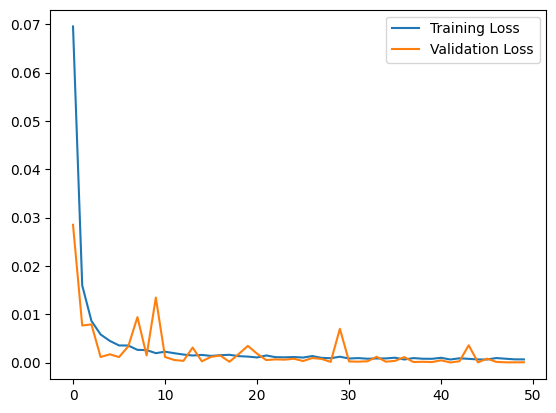

In [17]:
# Define the deep learning model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled_df.shape[1],)),  # Input size is number of features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled_df,
                    y_train,
                    epochs= 50,
                    batch_size=256,
                    validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [18]:
# 13. Make predictions

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled_df)

# Convert predicted probabilities to binary labels (0 or 1)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step


In [19]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.82      0.79        98

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962



Confusion Matrix:
[[56839    25]
 [   18    80]]


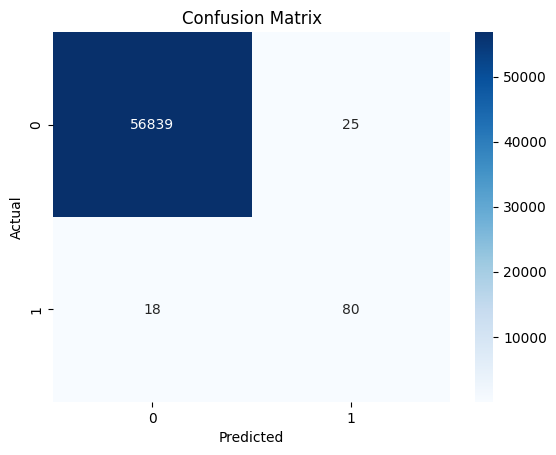

In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)
LABELS = ['0', '1']
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

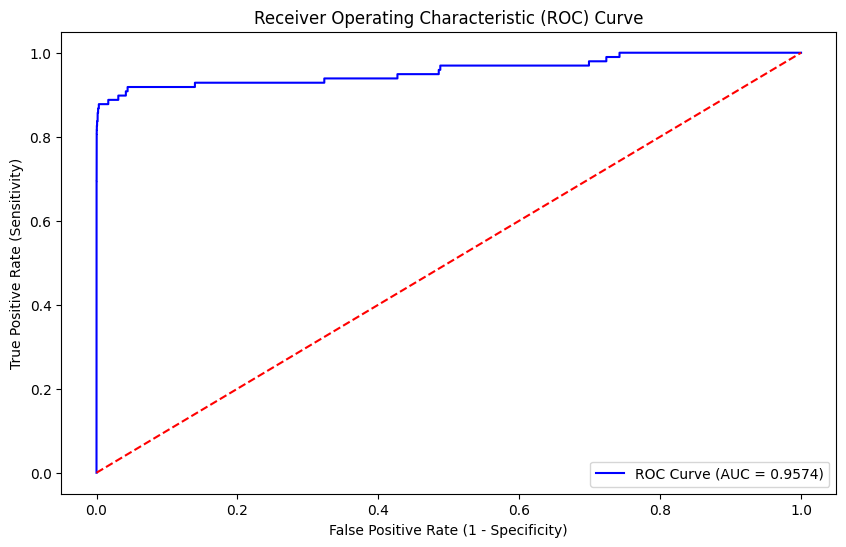

In [21]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [22]:
# prompt: Calcualte the false positive rate

# Assuming 'conf_matrix' is the confusion matrix from your code:
# conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Handle cases with zero true negatives and false positives

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.00043964546989307823


# Autoencoder = 100 epochs    FFNN = 150 epochs  

In [47]:
X_train_Autoencoder = X_train_scaled_df[y_train == 0]
#models.Sequential is a model from Keras where each layer feeds as input to the next layer.

autoencoder = models.Sequential([
    layers.Input(shape=(X_train_Autoencoder.shape[1],)),
    layers.Dense(32, activation='relu'), #(ReLu - Rectified Linear Unit) #encoding/compression
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(16, activation='relu'), #Process of decoding starts
    layers.Dense(32, activation='relu'),
    layers.Dense(X_train_Autoencoder.shape[1], activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with normal data
history = autoencoder.fit(X_train_Autoencoder, X_train_Autoencoder,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)



Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4876 - val_loss: 0.3714
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3626 - val_loss: 0.3606
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3530 - val_loss: 0.3579
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3607 - val_loss: 0.3523
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3464 - val_loss: 0.3474
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3617 - val_loss: 0.3457
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3362 - val_loss: 0.3449
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3397 - val_loss: 0.3441
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3453 - val_loss: 0.3434
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3391 - val_loss: 0.3350
Epoch 11/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3278 - val_loss: 0.3330
Epoch 12/100
800/800 ━━━━━━━━━━━━━━━━━━━━

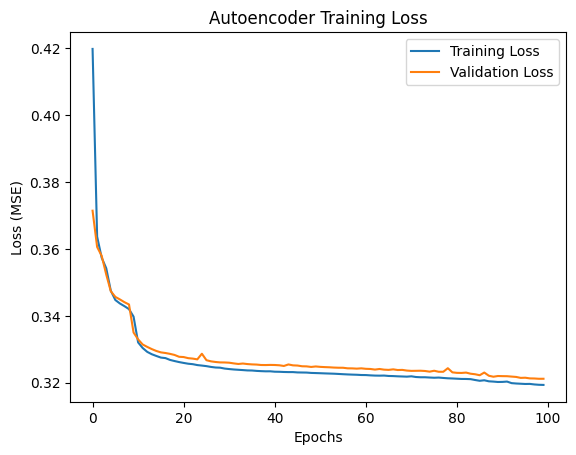

In [48]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [49]:
X_train_reconstructions = autoencoder.predict(X_train_scaled_df)
mse_train = np.mean(np.power(X_train_scaled_df - X_train_reconstructions, 2), axis=1)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=x_test.columns, index=x_test.index)
X_test_reconstructions = autoencoder.predict(X_test_scaled_df)
mse_test = np.mean(np.power(X_test_scaled_df - X_test_reconstructions, 2), axis=1)

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step


In [50]:
X_train_scaled_df['Reconstruction_Error'] = mse_train
X_test_scaled_df['Reconstruction_Error'] = mse_test

Epoch 1/100


/home/ragad_ahmed/.virtualenvs/Data_Mining/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9552 - loss: 0.1307 - val_accuracy: 0.9949 - val_loss: 0.0198
Epoch 2/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9949 - loss: 0.0175 - val_accuracy: 0.9979 - val_loss: 0.0143
Epoch 3/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9995 - val_loss: 0.0054
Epoch 4/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9985 - loss: 0.0058 - val_accuracy: 0.9995 - val_loss: 0.0040
Epoch 5/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9997 - val_loss: 0.0047
Epoch 6/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 7.0581e-04
Epoch 7/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 8/100
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9993 - loss: 0.0025 - 

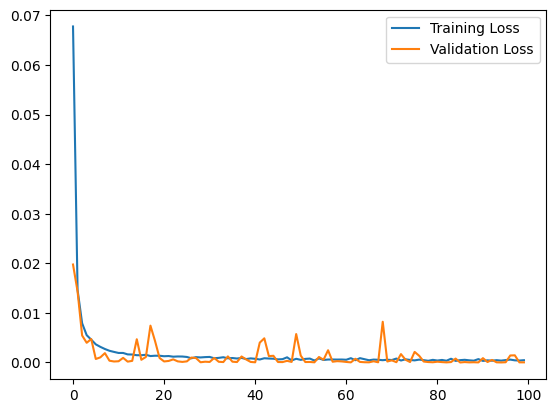

In [51]:
# Define the deep learning model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled_df.shape[1],)),  # Input size is number of features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled_df,
                    y_train,
                    epochs= 100,
                    batch_size=256,
                    validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [52]:
# 13. Make predictions

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled_df)

# Convert predicted probabilities to binary labels (0 or 1)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [53]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.79      0.77        98

    accuracy                           1.00     56962
   macro avg       0.87      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962



Confusion Matrix:
[[56838    26]
 [   21    77]]


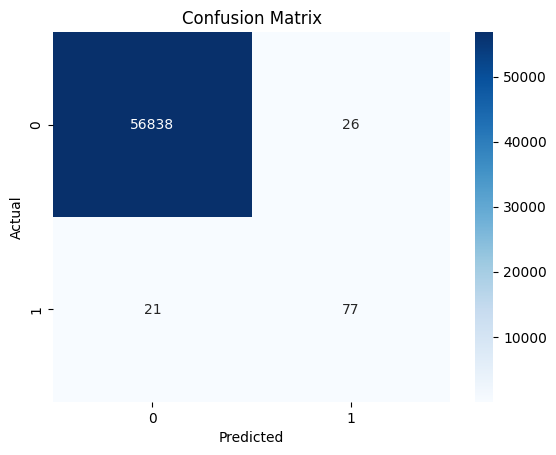

In [54]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)
LABELS = ['0', '1']
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

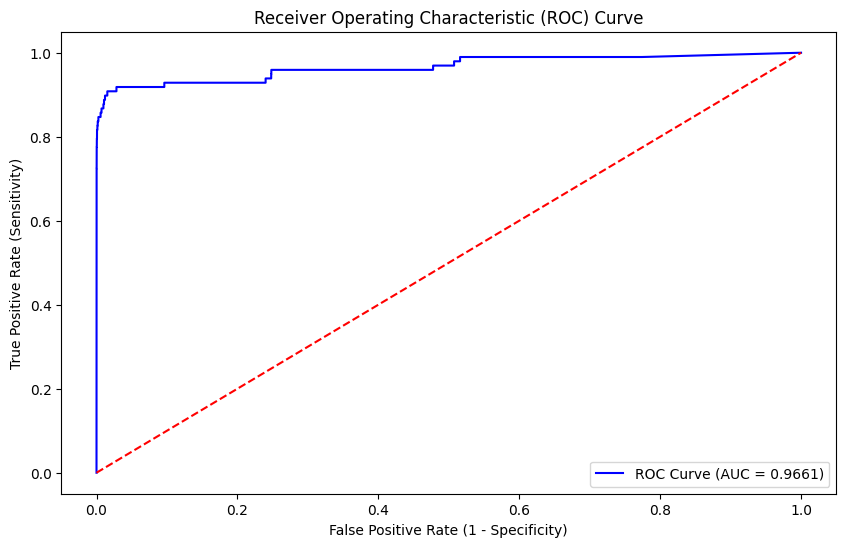

In [55]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [56]:
# prompt: Calcualte the false positive rate

# Assuming 'conf_matrix' is the confusion matrix from your code:
# conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Handle cases with zero true negatives and false positives

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.0004572312886888013


# Autoencoder = 100 epochs    FFNN = 10 epochs  

In [64]:
X_train_Autoencoder = X_train_scaled_df[y_train == 0]
#models.Sequential is a model from Keras where each layer feeds as input to the next layer.

autoencoder = models.Sequential([
    layers.Input(shape=(X_train_Autoencoder.shape[1],)),
    layers.Dense(32, activation='relu'), #(ReLu - Rectified Linear Unit) #encoding/compression
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(16, activation='relu'), #Process of decoding starts
    layers.Dense(32, activation='relu'),
    layers.Dense(X_train_Autoencoder.shape[1], activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with normal data
history = autoencoder.fit(X_train_Autoencoder, X_train_Autoencoder,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)



Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4578 - val_loss: 0.3627
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3577 - val_loss: 0.3492
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3580 - val_loss: 0.3448
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3335 - val_loss: 0.3425
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3376 - val_loss: 0.3413
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3449 - val_loss: 0.3401
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3313 - val_loss: 0.3393
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3335 - val_loss: 0.3387
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3389 - val_loss: 0.3379
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3298 - val_loss: 0.3370
Epoch 11/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3444 - val_loss: 0.3356
Epoch 12/100
800/800 ━━━━━━━━━━━━━━━━━━━━

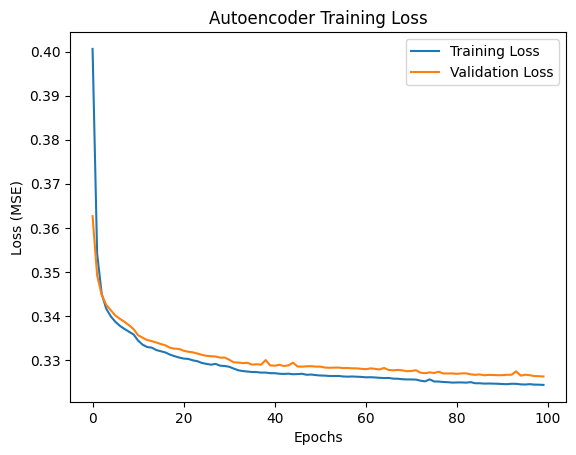

In [65]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [66]:
X_train_reconstructions = autoencoder.predict(X_train_scaled_df)
mse_train = np.mean(np.power(X_train_scaled_df - X_train_reconstructions, 2), axis=1)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=x_test.columns, index=x_test.index)
X_test_reconstructions = autoencoder.predict(X_test_scaled_df)
mse_test = np.mean(np.power(X_test_scaled_df - X_test_reconstructions, 2), axis=1)

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 921us/step


Epoch 1/10


/home/ragad_ahmed/.virtualenvs/Data_Mining/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9502 - loss: 0.1356 - val_accuracy: 0.9864 - val_loss: 0.0368
Epoch 2/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9953 - loss: 0.0175 - val_accuracy: 0.9989 - val_loss: 0.0094
Epoch 3/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9982 - loss: 0.0084 - val_accuracy: 0.9987 - val_loss: 0.0054
Epoch 4/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.9997 - val_loss: 0.0057
Epoch 5/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 6/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9999 - val_loss: 0.0022
Epoch 7/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 8/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accurac

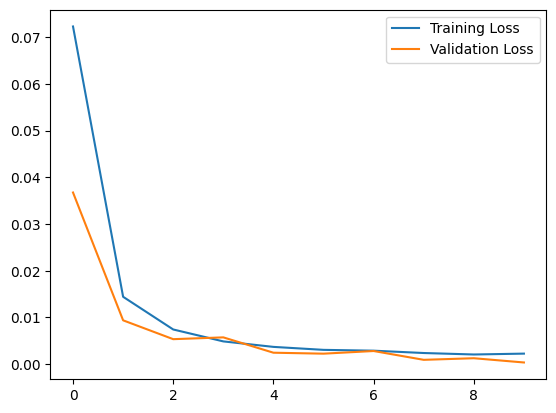

In [67]:
# Define the deep learning model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled_df.shape[1],)),  # Input size is number of features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled_df,
                    y_train,
                    epochs= 10,
                    batch_size=256,
                    validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [68]:
# 13. Make predictions

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled_df)

# Convert predicted probabilities to binary labels (0 or 1)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [69]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.80      0.68        98

    accuracy                           1.00     56962
   macro avg       0.80      0.90      0.84     56962
weighted avg       1.00      1.00      1.00     56962



Confusion Matrix:
[[56811    53]
 [   20    78]]


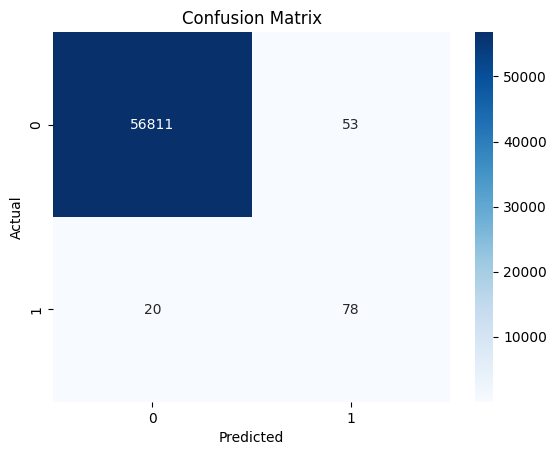

In [70]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)
LABELS = ['0', '1']
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

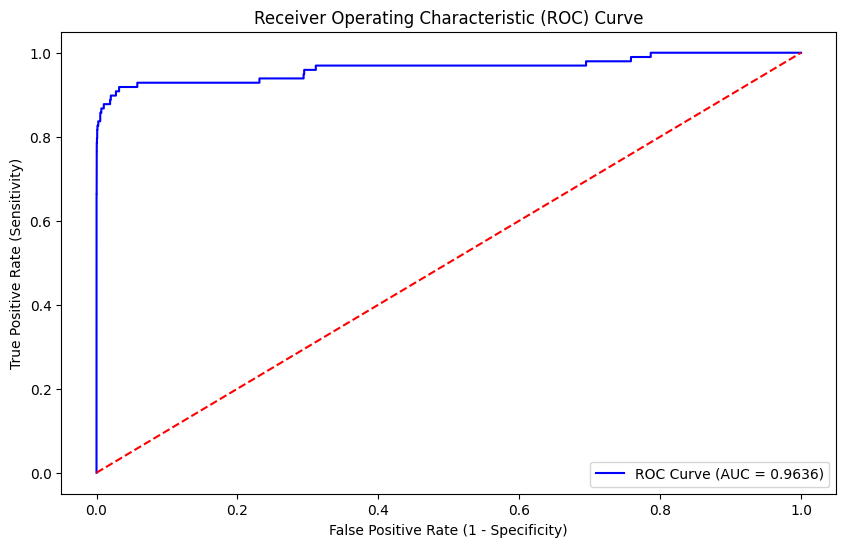

In [71]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [72]:
# prompt: Calcualte the false positive rate

# Assuming 'conf_matrix' is the confusion matrix from your code:
# conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Handle cases with zero true negatives and false positives

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.0009320483961733258


# Autoencoder = 150 epochs    FFNN = 150 epochs  

In [80]:
X_train_Autoencoder = X_train_scaled_df[y_train == 0]
#models.Sequential is a model from Keras where each layer feeds as input to the next layer.

autoencoder = models.Sequential([
    layers.Input(shape=(X_train_Autoencoder.shape[1],)),
    layers.Dense(32, activation='relu'), #(ReLu - Rectified Linear Unit) #encoding/compression
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),  # Bottleneck layer (smallest representation)
    layers.Dense(16, activation='relu'), #Process of decoding starts
    layers.Dense(32, activation='relu'),
    layers.Dense(X_train_Autoencoder.shape[1], activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with normal data
history = autoencoder.fit(X_train_Autoencoder, X_train_Autoencoder,
                          epochs=150,
                          batch_size=256,
                          validation_split=0.1,
                          shuffle=True)



Epoch 1/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4708 - val_loss: 0.3746
Epoch 2/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3693 - val_loss: 0.3639
Epoch 3/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3696 - val_loss: 0.3602
Epoch 4/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3576 - val_loss: 0.3538
Epoch 5/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3550 - val_loss: 0.3501
Epoch 6/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3405 - val_loss: 0.3484
Epoch 7/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3441 - val_loss: 0.3470
Epoch 8/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3356 - val_loss: 0.3459
Epoch 9/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3335 - val_loss: 0.3451
Epoch 10/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3466 - val_loss: 0.3444
Epoch 11/150
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3584 - val_loss: 0.3440
Epoch 12/150
800/800 ━━━━━━━━━━━━━━━━━━━━

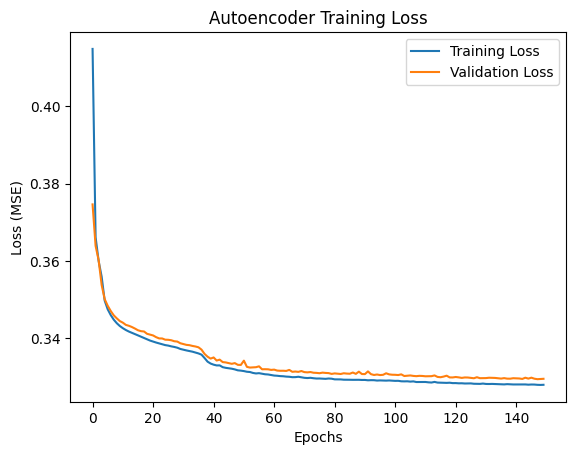

In [81]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [82]:
X_train_reconstructions = autoencoder.predict(X_train_scaled_df)
mse_train = np.mean(np.power(X_train_scaled_df - X_train_reconstructions, 2), axis=1)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=x_test.columns, index=x_test.index)
X_test_reconstructions = autoencoder.predict(X_test_scaled_df)
mse_test = np.mean(np.power(X_test_scaled_df - X_test_reconstructions, 2), axis=1)

14216/14216 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Epoch 1/150


/home/ragad_ahmed/.virtualenvs/Data_Mining/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9310 - loss: 0.1644 - val_accuracy: 0.9919 - val_loss: 0.0235
Epoch 2/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9945 - loss: 0.0187 - val_accuracy: 0.9997 - val_loss: 0.0082
Epoch 3/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9981 - loss: 0.0082 - val_accuracy: 0.9997 - val_loss: 0.0066
Epoch 4/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9989 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 5/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 6/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9978 - val_loss: 0.0120
Epoch 7/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9999 - val_loss: 0.0025
Epoch 8/150
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9994 - loss: 0.0024 - val_

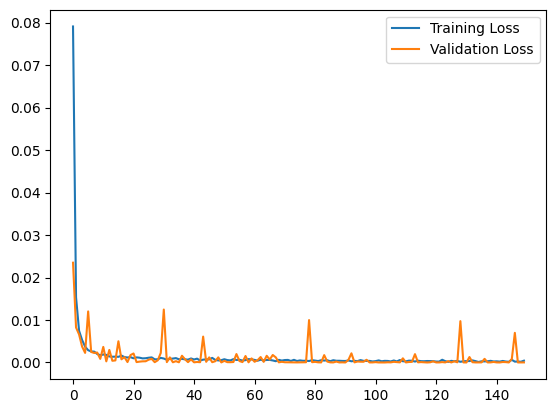

In [86]:
# Define the deep learning model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled_df.shape[1],)),  # Input size is number of features
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled_df,
                    y_train,
                    epochs= 150,
                    batch_size=256,
                    validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [87]:
# 13. Make predictions

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled_df)

# Convert predicted probabilities to binary labels (0 or 1)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [88]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.77      0.76        98

    accuracy                           1.00     56962
   macro avg       0.88      0.88      0.88     56962
weighted avg       1.00      1.00      1.00     56962



Confusion Matrix:
[[56840    24]
 [   23    75]]


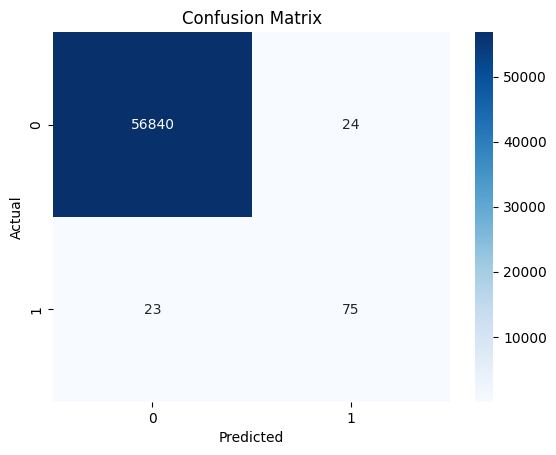

In [90]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)
LABELS = ['0', '1']
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

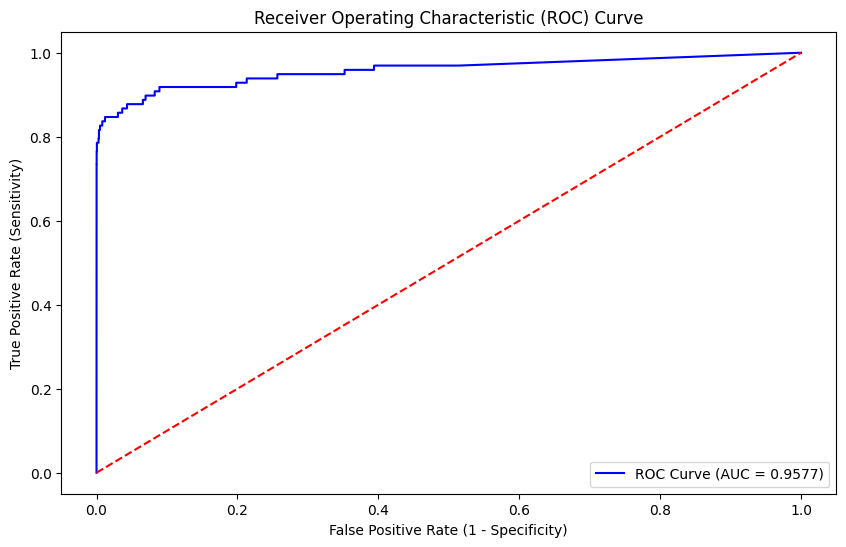

In [91]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [92]:
# prompt: Calcualte the false positive rate

# Assuming 'conf_matrix' is the confusion matrix from your code:
# conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Handle cases with zero true negatives and false positives

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.0004220596510973551
